# Packages

In [8]:
#basic packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
from datetime import datetime


#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


import shap

In [9]:
#linear models packages
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# from yellowbrick.regressor import PredictionError, ResidualsPlot

#PCA
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold

# Script

## Errors computation

In [10]:
#defining the Root Mean Squared Error

def rmse(y_true, y_predicted):
    
    return np.sqrt(mean_squared_error(y_true, y_predicted))

In [11]:
#errors computation

def errors_computation(data):
    
    df=pd.DataFrame()
    df.at['RMSE (as root mean)', 'Wind']= round(rmse(data['Target'], data['WS_pred']), 3)
    df.at['MAE (in avg)', 'Wind']= round(mae(data['Target'], data['WS_pred']), 3)
    df.at['MAPE (%)', 'Wind']= round(mape(data['Target'], data['WS_pred'])*100, 3)
    
    df.at['RMSE (as root mean)', 'Power']= round(rmse(data['P'], data['P_pred']), 3)
    df.at['MAE (in avg)', 'Power']= round(mae(data['P'], data['P_pred']), 3)
    df.at['MAPE (%)', 'Power']= round(mape(data['P'], data['P_pred'])*100, 3)
    
    
    print('Wind RMSE: ', round(rmse(data['Target'], data['WS_pred']), 3), 'm/s as root mean')
    print('Wind MAE: ', round(mae(data['Target'], data['WS_pred']), 3), 'm/s in avg')
    print('Wind MAPE: ', round(mape(data['Target'], data['WS_pred'])*100, 3), '%')
    
    print('Power RMSE: ', round(rmse(data['P'], data['P_pred']), 3), 'kW as root mean')
    print('Power MAE: ', round(mae(data['P'], data['P_pred']), 3), 'kW in avg')
    print('Power MAPE: ', round(mape(data['P'], data['P_pred'])*100, 3), '%')
    
    return df

In [12]:
def error_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot([-1,17.5],[-1,17.5], 'green', linewidth=4, alpha=.12)
    plt.plot(data['WS_pred'], data['Target'], marker='o', ls='', label='Regression', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='y predicted', ylabel='y actual');
    ax.set_title(title)
    ax.set_ylim(ymin=4, ymax=17.5)
    ax.set_xlim(xmin=4, xmax=17.5)
    
    return print('')

In [13]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # the power curve of the wind turbine in an xslx
    
    
    x=power_curve['Wind Speed [m/s]']
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)
    
    if 'WS_pred' in data.keys():
        x_new2=data['WS_pred']
        data['P_pred']=f(x_new2)
    
    print('power curve computation performed')
    
    return data

In [14]:
def control_power_computation (data_test, data_train, power_curve):
    
    results_test=pd.DataFrame()
    results_train=pd.DataFrame()
    
    
    results_test=powercurve_computation(data_test, power_curve)
    results_train=powercurve_computation(data_train, power_curve)

    return results_test, results_train

In [15]:
def compute_results(data_test, data_train, power_curve, plot):
    
    #this function computes and plots the results of a modelling:

    results_test, results_train=control_power_computation (data_test, data_train, power_curve)
    
    
    print('Modelling errors for training set:')
    errors_computation(results_train)
    print('')
    print('Modelling errors for test set:')
    errors_computation(results_test)
    
    if plot:
        print('')
        error_plot(results_test, 'Error plot for test set wind speed')

    print('')
    return print('Showing the results of the modelling: ')

## Data uploading

In [16]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [17]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

## Data selection

In [18]:
def data_selection(X_train, X_test, inputs):
    
    #this function returns the columns of the training and test sets in the inputs list
    
    X_train1 = pd.DataFrame()
    X_test1 = pd.DataFrame()
    
    
    X_train1 = X_train[inputs]
    X_test1 = X_test[inputs]

    
    return X_train1,X_test1
    

In [19]:
def data_drop(X_train, X_test, list_2drop):
    
    #this function returns the columns of the training and test sets in the inputs list

    X_train1 = X_train.drop(columns=list_2drop)
    X_test1 = X_test.drop(columns=list_2drop)

    
    
    return X_train1,X_test1

## Modelling

### Linear regression

In [20]:
def linear_regression(X_train, X_test, y_train, y_test, power_curve, plot):


    linr=LinearRegression()
    linr=linr.fit(X_train, y_train)

    y_pred_test=linr.predict(X_test)
    y_pred_train=linr.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    

    coefs=pd.DataFrame(linr.coef_.T, index=list(X_train.keys()), columns = ['Lin_reg coeffs'])
    
    coefs = coefs.sort_values(['Lin_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
        
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    
    compute_results(data_test, data_train, power_curve, plot)
    print('Linear regression & results performed')

    WS_pred=data_test['WS_pred']
    
    return linr,WS_pred

### Polynomial regression

In [35]:
def polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, power_curve, plot):
    
    
    X_poly = PolynomialFeatures_labeled(X_train,degree)
    X_poly_test = PolynomialFeatures_labeled(X_test,degree)
    
    if model=='linear':
        model_regression, WS_pred=linear_regression(X_poly, X_poly_test, y_train, y_test, power_curve, plot)
    elif model=='ridge':
        model_regression, WS_pred=ridgecv_regression(X_poly, X_poly_test, y_train, y_test, cv, alphas, power_curve, plot)
    elif model=='lasso':
        model_regression, WS_pred=lassocv_regression(X_poly, X_poly_test, y_train, y_test, cv, alphas, power_curve, plot)
    elif model=='elasticnet':
        model_regression, WS_pred=elasticnetcv_regression(X_poly, X_poly_test, y_train, y_test, cv, alphas, l1_ratios, power_curve, plot)
    print('')
    
    print('Polynomial regression & results performed')
    
    return model_regression, WS_pred

In [22]:
def PolynomialFeatures_labeled(input_df,power):
    '''Basically this is a cover for the sklearn preprocessing function. 
    The problem with that function is if you give it a labeled dataframe, it ouputs an unlabeled dataframe with potentially
    a whole bunch of unlabeled columns. 

    Inputs:
    input_df = Your labeled pandas dataframe (list of x's not raised to any power) 
    power = what order polynomial you want variables up to. (use the same power as you want entered into pp.PolynomialFeatures(power) directly)

    Ouput:
    Output: This function relies on the powers_ matrix which is one of the preprocessing function's outputs to create logical labels and 
    outputs a labeled pandas dataframe   
    '''
    poly = PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s^%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + " x " + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

### Ridge regression

In [23]:
def ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, power_curve, plot):
    

    ridgeCV=RidgeCV(alphas=alphas,
                   cv=cv).fit(X_train, y_train.values.ravel())

    y_pred_test=ridgeCV.predict(X_test)
    y_pred_train=ridgeCV.predict(X_train)
    
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    print('Best alpha: ', ridgeCV.alpha_)
    print('')
    
    
    coefs=pd.DataFrame(ridgeCV.coef_.T, index=list(X_train.keys()), columns = ['RidgeCV_reg coeffs'])
    
    print('Of {} coefficients, {} are non-zero with RidgeCV.'. format(len(coefs),int(coefs.astype(bool).sum(axis=0).values)))
    
    coefs = coefs.sort_values(['RidgeCV_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
    
    
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    
    
    print('')
    compute_results(data_test, data_train, power_curve, plot)
    print('')
    print('RidgeCV regression & results performed')
    
    WS_pred=data_test['WS_pred']
    
    return ridgeCV,WS_pred


### Lasso regression

In [24]:
def lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, power_curve, plot):
    

    
    lassoCV=LassoCV(alphas=alphas,
                   cv=cv).fit(X_train, y_train.values.ravel())

    y_pred_test=lassoCV.predict(X_test)
    y_pred_train=lassoCV.predict(X_train)
    
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    print('Best alpha: ', lassoCV.alpha_)
    print('')
    
    
    coefs=pd.DataFrame(lassoCV.coef_.T, index=list(X_train.keys()), columns = ['LassoCV_reg coeffs'])
    
    print('Of {} coefficients, {} are non-zero with LassoCV.'. format(len(coefs),int(coefs.astype(bool).sum(axis=0).values)))
    
    coefs = coefs.sort_values(['LassoCV_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
    
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    print('')
    compute_results(data_test, data_train, power_curve, plot)
    print('')
    print('LassoCV regression & results performed')
    
    
    WS_pred=data_test['WS_pred']
    
    return lassoCV,WS_pred

### ElasticNet regression

In [25]:
def elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, power_curve, plot):
    
#     The first machine learning model taken into consideration is the polynomial with
#     regularization. The regularization technique chosen is known as "Elastic Net" which
#     is a middle point between Ridge Regression and Lasso Regression.
#     When r=0--> Ridge
#     When r=1--> Lasso

    elasticNetCV= ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=cv,
                               max_iter=1e4).fit(X_train, y_train.values.ravel())

    y_pred_test=elasticNetCV.predict(X_test)
    y_pred_train=elasticNetCV.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    print('Best alpha: ', elasticNetCV.alpha_)
    print('')
    print('Best l1_ratio: ' , elasticNetCV.l1_ratio_)
    
    
    coefs=pd.DataFrame(elasticNetCV.coef_.T, index=list(X_train.keys()), columns = ['ElasticNetCV_reg coeffs'])
    
    print('Of {} coefficients, {} are non-zero with ElasticNetCV.'. format(len(coefs),int(coefs.astype(bool).sum(axis=0).values)))
    
    
    coefs = coefs.sort_values(['ElasticNetCV_reg coeffs'], ascending=True)
    
    coefs = coefs[(coefs.T != 0).any()]
    
    coefs.plot(kind='barh', figsize=(9, len(coefs)*0.27))
    plt.title('Linear model Coefficients')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    
    print('')
    compute_results(data_test, data_train, power_curve, plot)
    print('')
    print('ElasticNetCV regression & results performed')
    
    WS_pred=data_test['WS_pred']
    
    return elasticNetCV,WS_pred

## Feature importance

In [26]:
def feature_importance (X_train, X_test, model):
    

    X100=shap.utils.sample(X_test, 100)
    
    explainer = shap.Explainer(model.predict, X100)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    shap.plots.beeswarm(shap_values)
    
    
    print('Feature importance through SHAP values performed')
    
    return shap_values

In [27]:
def transform_shap (shap_values, X_test):

    v=np.array(shap_values.values)
    d=v.reshape(X_test.shape)
    shap_v=pd.DataFrame(d)
    
    feature_list=X_test.columns
    shap_v.columns=feature_list
    shap_v=shap_v.abs()
    k=pd.DataFrame(shap_v.mean()).reset_index()
    k.columns=['variables','SHAP_abs']
    k.sort_values(by='variables')
    
    return k

# Data analysis

## Dataset2- T11

In [28]:
#upload the dataset with file_folder, file_name
# data_up= uploading_csv('\Dataset1-Normal_Site','\data_comp14.csv')
X_train= uploading_csv('\Dataset2-Complex_Site','\X_train11.csv')
X_test= uploading_csv('\Dataset2-Complex_Site','\X_test11.csv')
y_train= uploading_csv('\Dataset2-Complex_Site','\y_train11.csv')
y_test= uploading_csv('\Dataset2-Complex_Site','\y_test11.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'T1',
       'RH1', 'PR1', 'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'AD1',
       'tod'],
      dtype='object')

In [29]:
y_test.keys()

Index(['Target'], dtype='object')

In [30]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V117.csv')

### Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.891 m/s as root mean
Wind MAE:  0.662 m/s in avg
Wind MAPE:  9.496 %
Power RMSE:  318.042 kW as root mean
Power MAE:  182.068 kW in avg
Power MAPE:  9.805388797748524e+17 %

Modelling errors for test set:
Wind RMSE:  0.953 m/s as root mean
Wind MAE:  0.683 m/s in avg
Wind MAPE:  11.81 %
Power RMSE:  344.82 kW as root mean
Power MAE:  189.344 kW in avg
Power MAPE:  2.167869530258535e+18 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

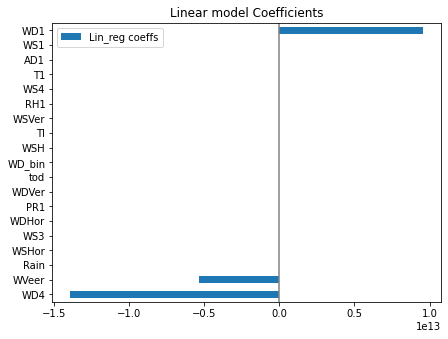

In [24]:
#results with all the variables

linear_regression(X_train, X_test, y_train, y_test, PC, plot=False)

### Polynomial Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.782 m/s as root mean
Wind MAE:  0.576 m/s in avg
Wind MAPE:  8.448 %
Power RMSE:  278.447 kW as root mean
Power MAE:  157.243 kW in avg
Power MAPE:  9.259844023618115e+17 %

Modelling errors for test set:
Wind RMSE:  0.87 m/s as root mean
Wind MAE:  0.61 m/s in avg
Wind MAPE:  10.933 %
Power RMSE:  311.135 kW as root mean
Power MAE:  168.331 kW in avg
Power MAPE:  2.1143823208463852e+18 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


LinearRegression()

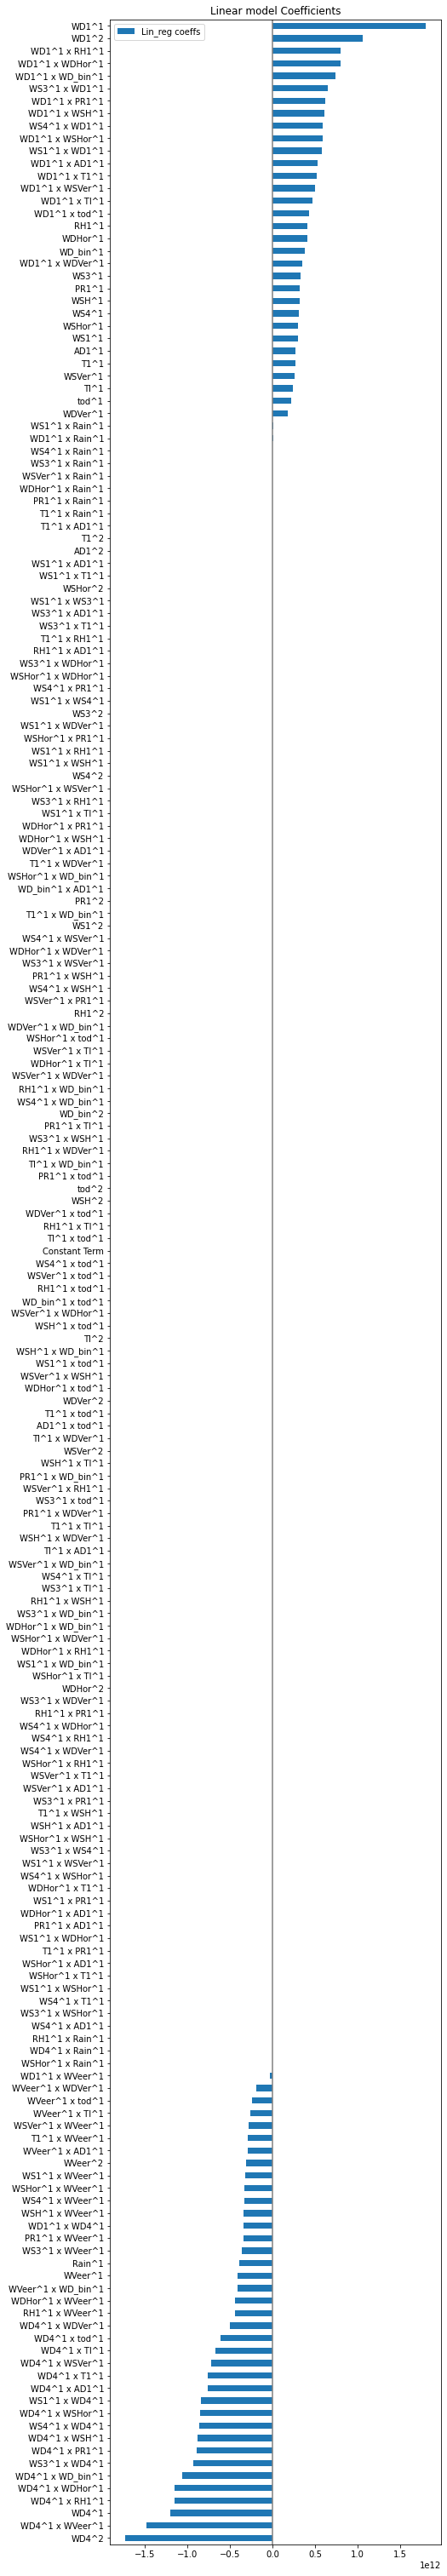

In [25]:
degree=2
cv=None
alphas=None
model='linear'
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Ridge regression

Best alpha:  0.001

Of 19 coefficients, 18 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.891 m/s as root mean
Wind MAE:  0.662 m/s in avg
Wind MAPE:  9.498 %
Power RMSE:  318.117 kW as root mean
Power MAE:  182.14 kW in avg
Power MAPE:  9.804767923108556e+17 %

Modelling errors for test set:
Wind RMSE:  0.953 m/s as root mean
Wind MAE:  0.683 m/s in avg
Wind MAPE:  11.814 %
Power RMSE:  345.04 kW as root mean
Power MAE:  189.496 kW in avg
Power MAPE:  2.1694118959987648e+18 %

Showing the results of the modelling: 

RidgeCV regression & results performed


RidgeCV(alphas=array([3.0e-04, 4.0e-04, 5.0e-04, 1.0e-03, 3.0e-03, 5.0e-03, 1.0e-02,
       3.0e-02, 5.0e-02, 1.0e-01, 3.0e-01, 5.0e-01, 1.0e+01, 5.0e+01,
       8.0e+01, 1.2e+02, 3.0e+02, 5.0e+02]),
        cv=4)

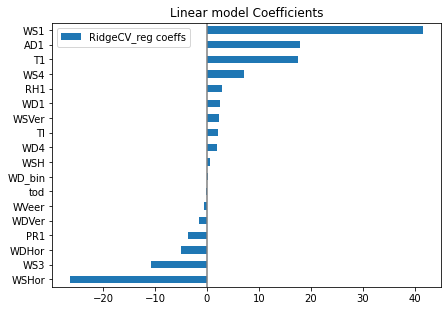

In [26]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Ridge regression

Best alpha:  0.0003

Of 210 coefficients, 189 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.786 m/s as root mean
Wind MAE:  0.578 m/s in avg
Wind MAPE:  8.495 %
Power RMSE:  279.894 kW as root mean
Power MAE:  157.89 kW in avg
Power MAPE:  9.333614690539306e+17 %

Modelling errors for test set:
Wind RMSE:  0.867 m/s as root mean
Wind MAE:  0.609 m/s in avg
Wind MAPE:  10.863 %
Power RMSE:  310.005 kW as root mean
Power MAE:  167.649 kW in avg
Power MAPE:  2.101868993769588e+18 %

Showing the results of the modelling: 

RidgeCV regression & results performed

Polynomial regression & results performed


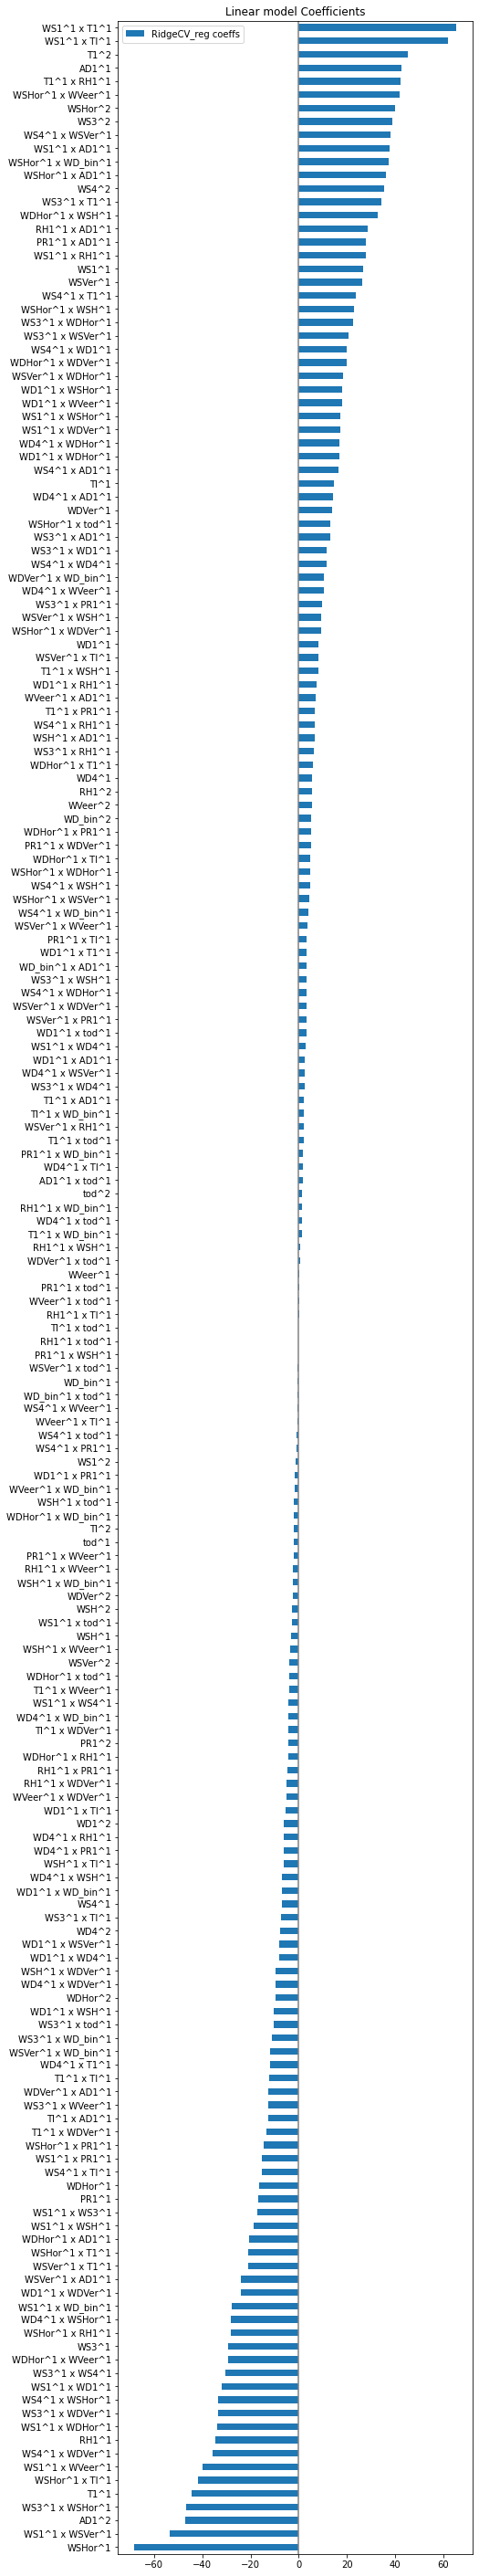

In [36]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='ridge'
cv=4
l1_ratios=None



model, WS_pred=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC,plot=False)

In [37]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','LR_T11.csv')

file LR_T11.csv saved in \Results_ folder


### Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.364192878725135, tolerance: 4.2919544173351465
Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.282434229173759, tolerance: 4.2919544173351465
Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.687834880010087, tolerance: 4.229816044913291
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.795784904846187, tolerance: 4.229816044913291


Best alpha:  0.0003

Of 19 coefficients, 13 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.899 m/s as root mean
Wind MAE:  0.671 m/s in avg
Wind MAPE:  9.577 %
Power RMSE:  320.02 kW as root mean
Power MAE:  183.958 kW in avg
Power MAPE:  9.807015194814522e+17 %

Modelling errors for test set:
Wind RMSE:  0.96 m/s as root mean
Wind MAE:  0.693 m/s in avg
Wind MAPE:  11.869 %
Power RMSE:  348.391 kW as root mean
Power MAE:  192.535 kW in avg
Power MAPE:  2.154279872167834e+18 %

Showing the results of the modelling: 

LassoCV regression & results performed


Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.70821147555353, tolerance: 5.683640513381752


LassoCV(alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05,
                0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500],
        cv=4)

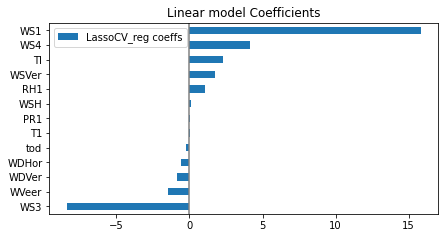

In [28]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Lasso regression

Best alpha:  0.001

Of 210 coefficients, 34 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.836 m/s as root mean
Wind MAE:  0.615 m/s in avg
Wind MAPE:  8.972 %
Power RMSE:  296.407 kW as root mean
Power MAE:  167.326 kW in avg
Power MAPE:  9.734350370977036e+17 %

Modelling errors for test set:
Wind RMSE:  0.905 m/s as root mean
Wind MAE:  0.637 m/s in avg
Wind MAPE:  11.337 %
Power RMSE:  323.553 kW as root mean
Power MAE:  175.595 kW in avg
Power MAPE:  2.1814830760576264e+18 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50,
                80, 120, 300, 500],
        cv=4)

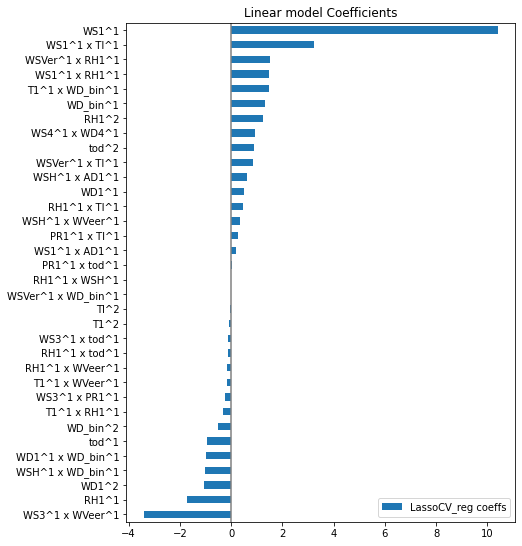

In [29]:
alphas=[0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### ElasticNet regression

Best alpha:  0.001

Best l1_ratio:  0.9
Of 19 coefficients, 13 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.911 m/s as root mean
Wind MAE:  0.683 m/s in avg
Wind MAPE:  9.695 %
Power RMSE:  324.508 kW as root mean
Power MAE:  187.18 kW in avg
Power MAPE:  9.801510629075948e+17 %

Modelling errors for test set:
Wind RMSE:  0.974 m/s as root mean
Wind MAE:  0.704 m/s in avg
Wind MAPE:  12.048 %
Power RMSE:  353.166 kW as root mean
Power MAE:  196.325 kW in avg
Power MAPE:  2.1695702026103992e+18 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

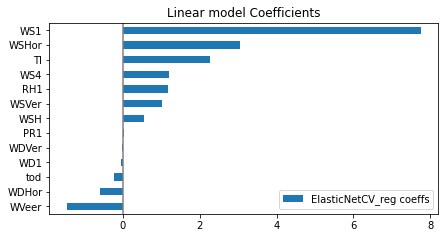

In [30]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

### Polynomial ElasticNet regression

Best alpha:  0.005

Best l1_ratio:  0.1
Of 210 coefficients, 131 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.867 m/s as root mean
Wind MAE:  0.645 m/s in avg
Wind MAPE:  9.32 %
Power RMSE:  306.149 kW as root mean
Power MAE:  176.279 kW in avg
Power MAPE:  9.752995946592957e+17 %

Modelling errors for test set:
Wind RMSE:  0.931 m/s as root mean
Wind MAE:  0.662 m/s in avg
Wind MAPE:  11.649 %
Power RMSE:  331.817 kW as root mean
Power MAE:  182.769 kW in avg
Power MAPE:  2.1899780249437545e+18 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed

Polynomial regression & results performed


ElasticNetCV(alphas=array([5.0e-03, 5.0e-02, 1.0e-01, 1.0e+00, 5.0e+00, 2.0e+01, 5.0e+01,
       8.0e+01, 1.0e+02, 1.2e+02, 1.4e+02]),
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

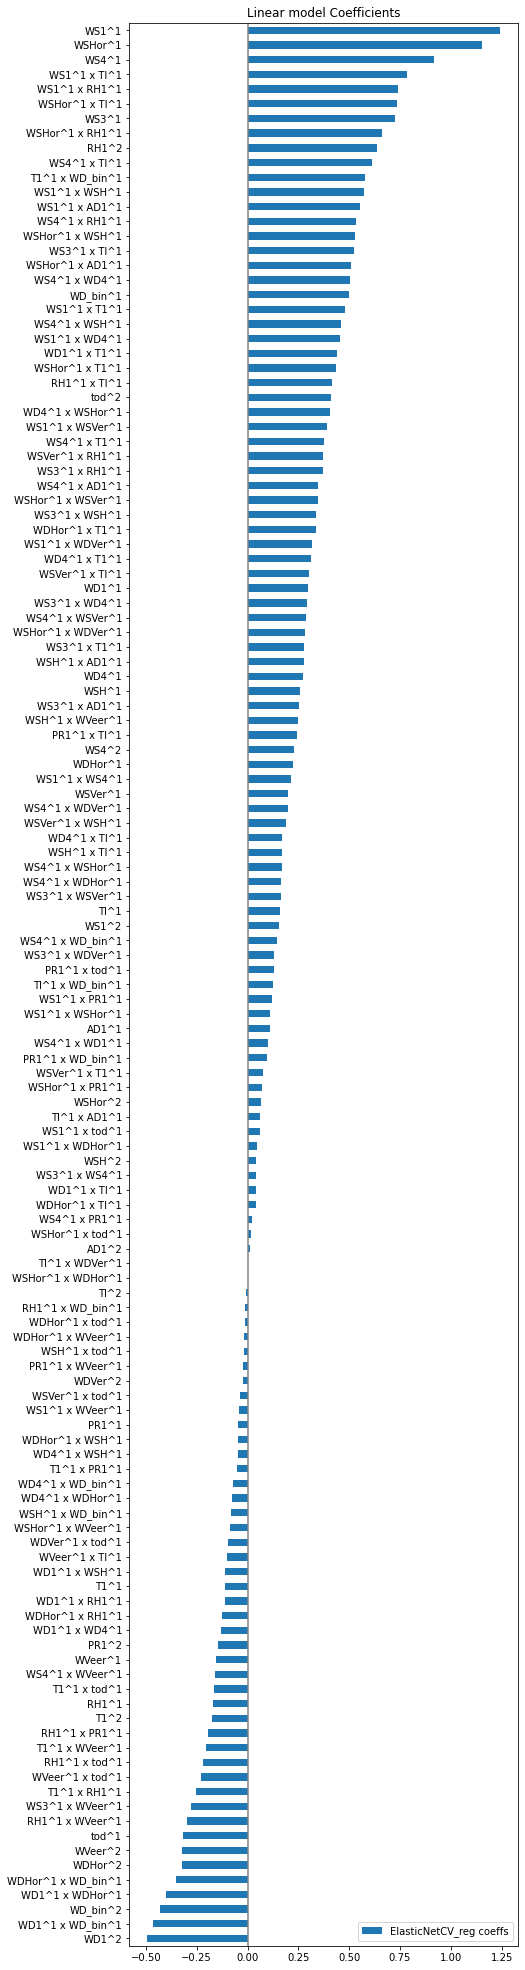

In [31]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=np.array([0.005, 0.05, 0.1, 1, 5, 20, 50, 80, 100, 120, 140])
degree=2
model='elasticnet'
cv=4



polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

## Feature importance

In [26]:
X_test_poly=PolynomialFeatures_labeled(X_test,2)

In [27]:
X_train_poly=PolynomialFeatures_labeled(X_train,2)

Permutation explainer: 2783it [1:08:06,  1.47s/it]                          


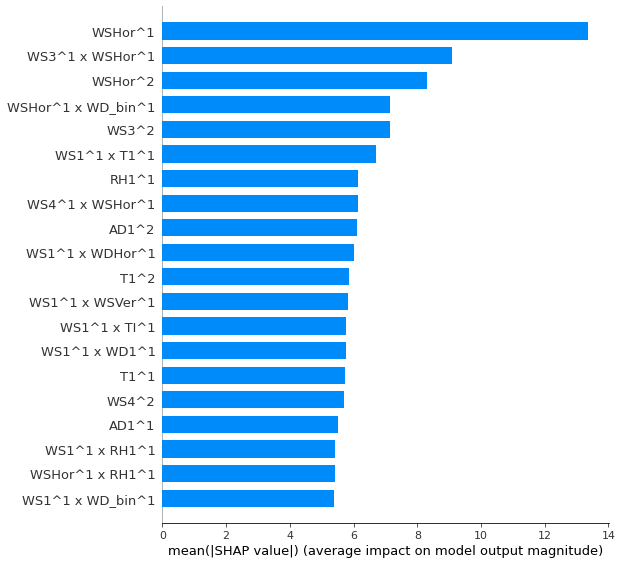

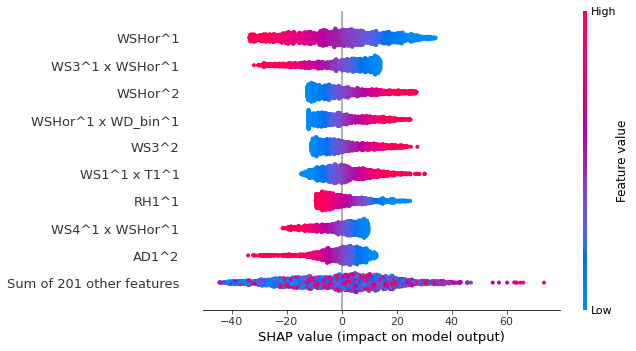

Feature importance through SHAP values performed


In [28]:
shap_values=feature_importance (X_train_poly, X_test_poly, model)

In [29]:
k=transform_shap (shap_values, X_test_poly)

In [31]:
save(k,'\Dataset1-Normal_Site','\SHAP_values_LR_T11.csv')

file \SHAP_values_LR_T11.csv saved in \Dataset1-Normal_Site folder


## Dataset2- T17

In [21]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset2-Complex_Site','\X_train17.csv')
X_test= uploading_csv('\Dataset2-Complex_Site','\X_test17.csv')
y_train= uploading_csv('\Dataset2-Complex_Site','\y_train17.csv')
y_test= uploading_csv('\Dataset2-Complex_Site','\y_test17.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'PR1',
       'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [22]:
y_test.keys()

Index(['Target'], dtype='object')

In [23]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V112.csv')

### Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.658 m/s as root mean
Wind MAE:  0.515 m/s in avg
Wind MAPE:  5.598 %
Power RMSE:  274.008 kW as root mean
Power MAE:  178.405 kW in avg
Power MAPE:  12.764 %

Modelling errors for test set:
Wind RMSE:  0.642 m/s as root mean
Wind MAE:  0.498 m/s in avg
Wind MAPE:  5.399 %
Power RMSE:  255.932 kW as root mean
Power MAE:  168.21 kW in avg
Power MAPE:  12.225 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

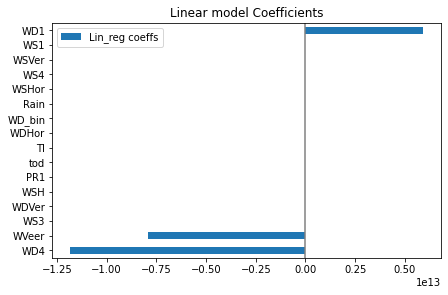

In [24]:
#results with all the variables
linear_regression(X_train, X_test, y_train, y_test, PC, plot=False)

### Polynomial Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.582 m/s as root mean
Wind MAE:  0.45 m/s in avg
Wind MAPE:  4.848 %
Power RMSE:  241.434 kW as root mean
Power MAE:  155.221 kW in avg
Power MAPE:  10.933 %

Modelling errors for test set:
Wind RMSE:  0.596 m/s as root mean
Wind MAE:  0.462 m/s in avg
Wind MAPE:  4.97 %
Power RMSE:  236.203 kW as root mean
Power MAE:  154.543 kW in avg
Power MAPE:  11.16 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


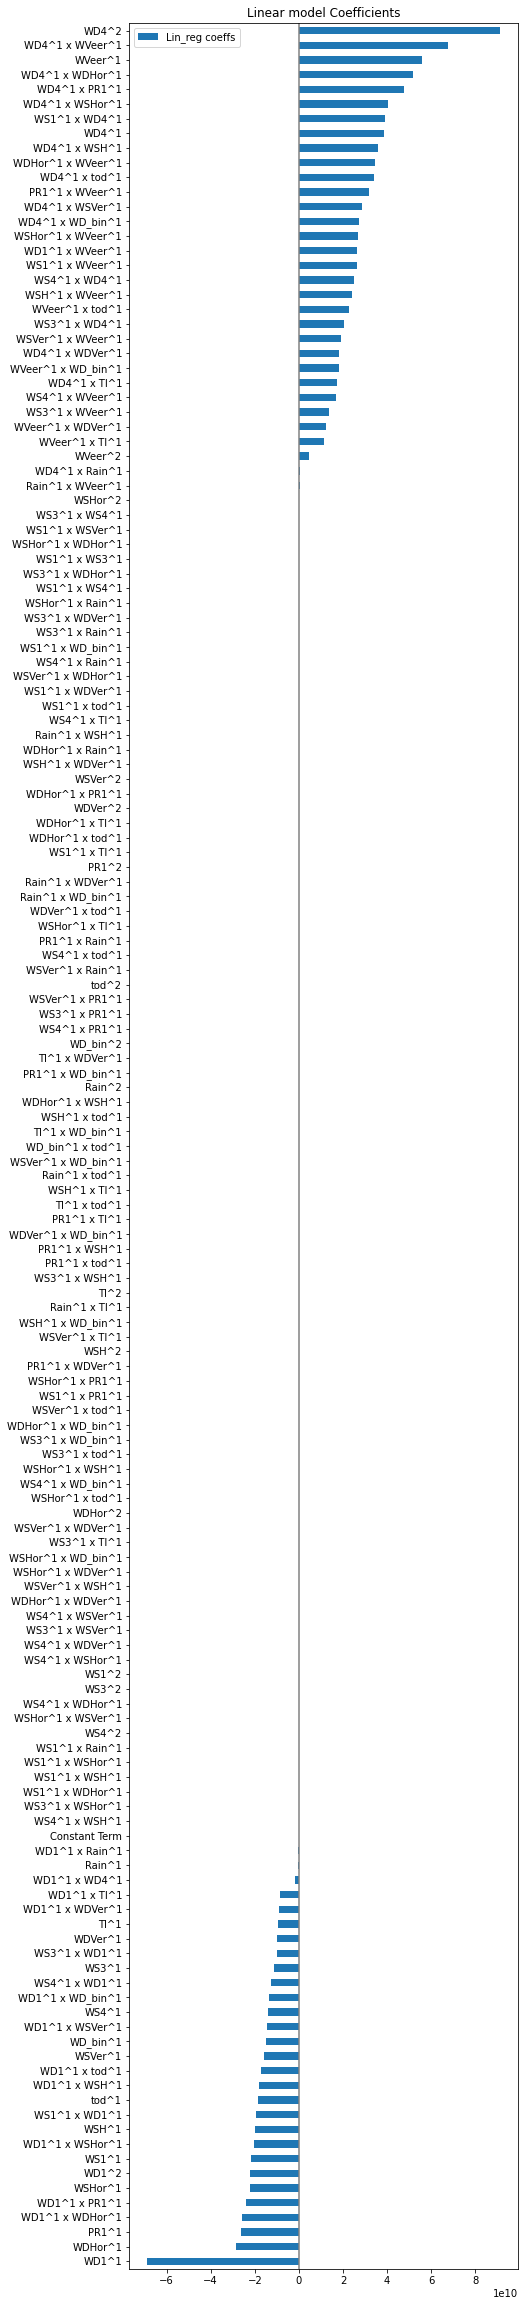

In [35]:
degree=2
cv=None
alphas=None
model='linear'
l1_ratios=None
model=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Ridge regression

Best alpha:  0.001

Of 16 coefficients, 16 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.658 m/s as root mean
Wind MAE:  0.515 m/s in avg
Wind MAPE:  5.598 %
Power RMSE:  274.041 kW as root mean
Power MAE:  178.373 kW in avg
Power MAPE:  12.766 %

Modelling errors for test set:
Wind RMSE:  0.642 m/s as root mean
Wind MAE:  0.498 m/s in avg
Wind MAPE:  5.4 %
Power RMSE:  255.893 kW as root mean
Power MAE:  168.186 kW in avg
Power MAPE:  12.226 %

Showing the results of the modelling: 

RidgeCV regression & results performed


RidgeCV(alphas=array([3.0e-04, 4.0e-04, 5.0e-04, 1.0e-03, 3.0e-03, 5.0e-03, 1.0e-02,
       3.0e-02, 5.0e-02, 1.0e-01, 3.0e-01, 5.0e-01, 1.0e+01, 5.0e+01,
       8.0e+01, 1.2e+02, 3.0e+02, 5.0e+02]),
        cv=4)

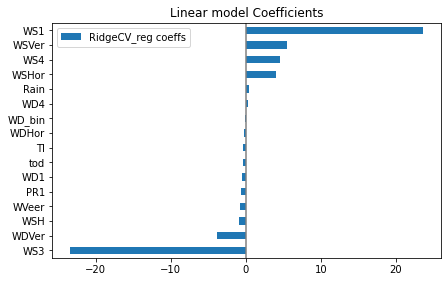

In [26]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Ridge regression

Best alpha:  0.05

Of 153 coefficients, 152 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.597 m/s as root mean
Wind MAE:  0.461 m/s in avg
Wind MAPE:  4.95 %
Power RMSE:  245.86 kW as root mean
Power MAE:  158.173 kW in avg
Power MAPE:  11.121 %

Modelling errors for test set:
Wind RMSE:  0.599 m/s as root mean
Wind MAE:  0.466 m/s in avg
Wind MAPE:  5.006 %
Power RMSE:  235.517 kW as root mean
Power MAE:  154.8 kW in avg
Power MAPE:  11.179 %

Showing the results of the modelling: 

RidgeCV regression & results performed

Polynomial regression & results performed


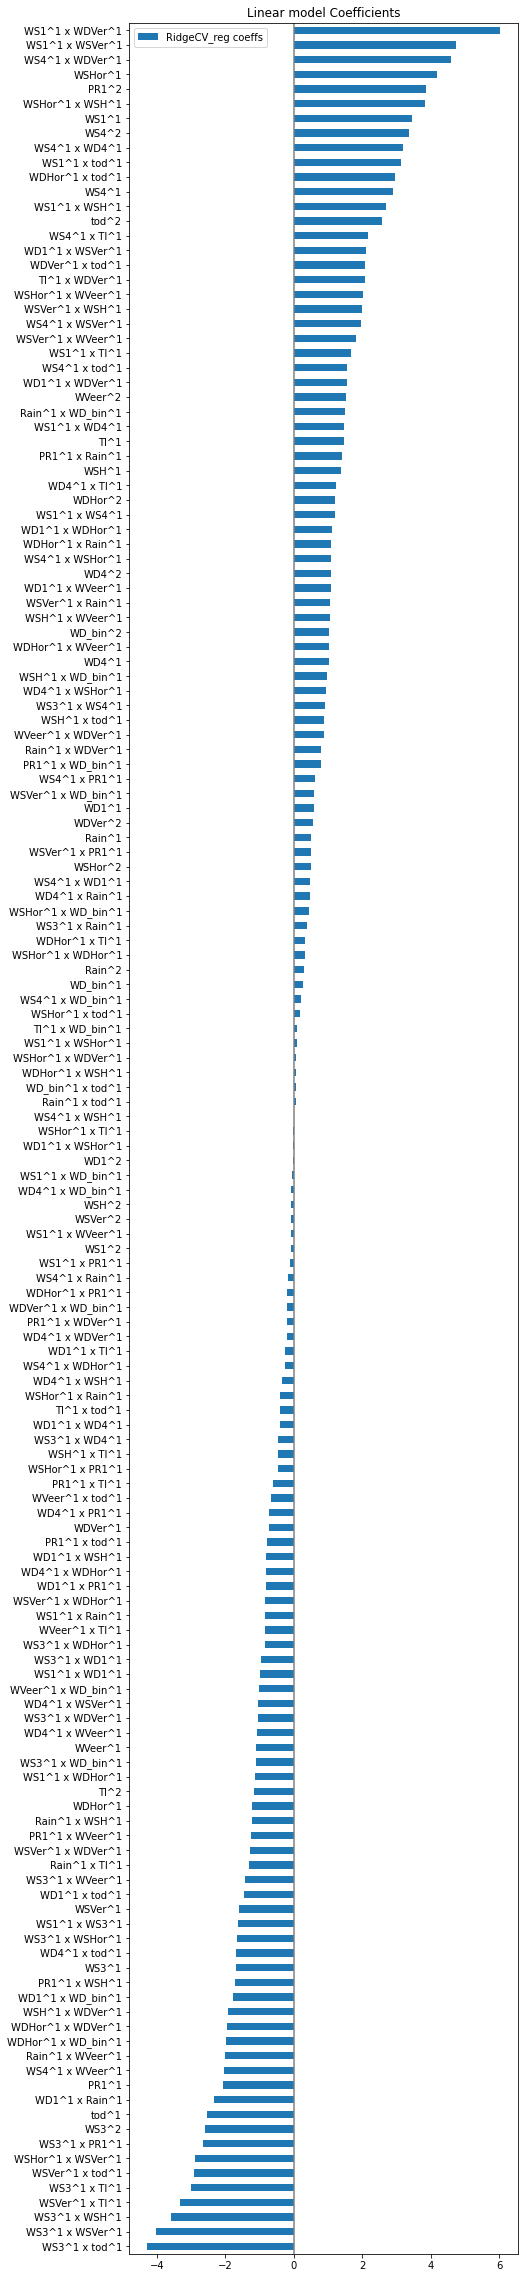

In [24]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='ridge'
cv=4
l1_ratios=None


model=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 39.06319470851713, tolerance: 2.4186744064647177
Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.37348861658484, tolerance: 2.4186744064647177
Objective did not converge. You might want to increase the number of iterations. Duality gap: 22.352352427664073, tolerance: 2.4186744064647177
Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.144667169631248, tolerance: 2.4186744064647177
Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.24056818197141, tolerance: 2.43565176949111
Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.24515018893362, tolerance: 2.43565176949111
Objective did not converge. You might want to increase the number of iterations. Duality gap: 28.79274304584783, tolerance: 2.43565176949111
Obj

Best alpha:  0.0003

Of 16 coefficients, 15 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.661 m/s as root mean
Wind MAE:  0.516 m/s in avg
Wind MAPE:  5.605 %
Power RMSE:  275.002 kW as root mean
Power MAE:  178.54 kW in avg
Power MAPE:  12.766 %

Modelling errors for test set:
Wind RMSE:  0.643 m/s as root mean
Wind MAE:  0.499 m/s in avg
Wind MAPE:  5.398 %
Power RMSE:  255.816 kW as root mean
Power MAE:  167.679 kW in avg
Power MAPE:  12.196 %

Showing the results of the modelling: 

LassoCV regression & results performed


Objective did not converge. You might want to increase the number of iterations. Duality gap: 289.5440641863232, tolerance: 3.2539856667704723


LassoCV(alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05,
                0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500],
        cv=4)

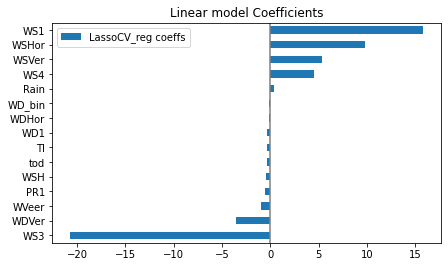

In [28]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.780864276081047, tolerance: 2.4186744064647177
Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.088800787480068, tolerance: 2.4186744064647177
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.569659422003269, tolerance: 2.43565176949111
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6529223796737824, tolerance: 2.43565176949111
Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.726473143409748, tolerance: 2.40523230023222
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.206690931685216, tolerance: 2.40523230023222
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.071835600815575, tolerance: 2.502021558793656
Objec

Best alpha:  0.0005

Of 153 coefficients, 42 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.618 m/s as root mean
Wind MAE:  0.478 m/s in avg
Wind MAPE:  5.13 %
Power RMSE:  256.694 kW as root mean
Power MAE:  165.041 kW in avg
Power MAPE:  11.561 %

Modelling errors for test set:
Wind RMSE:  0.61 m/s as root mean
Wind MAE:  0.472 m/s in avg
Wind MAPE:  5.077 %
Power RMSE:  240.754 kW as root mean
Power MAE:  157.515 kW in avg
Power MAPE:  11.345 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5,
                10, 50, 80, 120, 300, 500],
        cv=4)

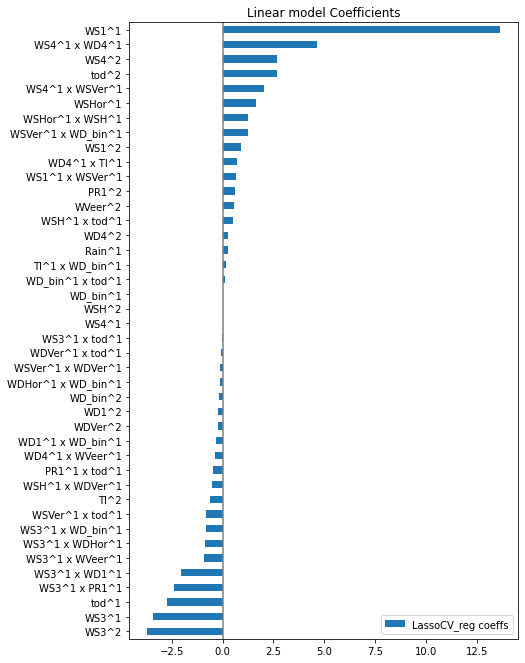

In [29]:
alphas=[0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv,  alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### ElasticNet regression

Best alpha:  0.001

Best l1_ratio:  0.9
Of 16 coefficients, 14 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.699 m/s as root mean
Wind MAE:  0.544 m/s in avg
Wind MAPE:  5.9 %
Power RMSE:  290.447 kW as root mean
Power MAE:  187.934 kW in avg
Power MAPE:  13.472 %

Modelling errors for test set:
Wind RMSE:  0.682 m/s as root mean
Wind MAE:  0.528 m/s in avg
Wind MAPE:  5.716 %
Power RMSE:  268.847 kW as root mean
Power MAE:  176.836 kW in avg
Power MAPE:  12.968 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.012], cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

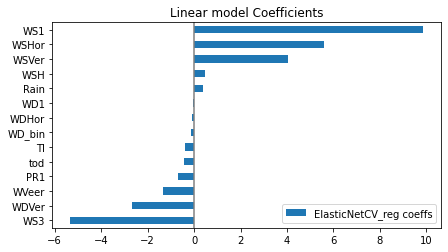

In [31]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.012]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

Best alpha:  0.0005

Best l1_ratio:  0.9
Of 16 coefficients, 14 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.677 m/s as root mean
Wind MAE:  0.528 m/s in avg
Wind MAPE:  5.724 %
Power RMSE:  281.835 kW as root mean
Power MAE:  182.467 kW in avg
Power MAPE:  13.058 %

Modelling errors for test set:
Wind RMSE:  0.659 m/s as root mean
Wind MAE:  0.51 m/s in avg
Wind MAPE:  5.523 %
Power RMSE:  260.831 kW as root mean
Power MAE:  171.248 kW in avg
Power MAPE:  12.501 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

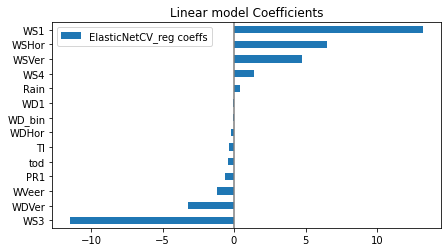

In [32]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

### Polynomial ElasticNet regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.60506120973082, tolerance: 2.4186744064647177
Objective did not converge. You might want to increase the number of iterations. Duality gap: 35.41955224813728, tolerance: 2.43565176949111
Objective did not converge. You might want to increase the number of iterations. Duality gap: 23.57295050175344, tolerance: 2.40523230023222
Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.07165108890035, tolerance: 2.502021558793656
Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.921384516565922, tolerance: 2.4186744064647177
Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.296265198287074, tolerance: 2.43565176949111
Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.448838514274712, tolerance: 2.40523230023222
Object

Best alpha:  0.0005

Best l1_ratio:  0.9
Of 153 coefficients, 50 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.621 m/s as root mean
Wind MAE:  0.48 m/s in avg
Wind MAPE:  5.155 %
Power RMSE:  257.855 kW as root mean
Power MAE:  165.732 kW in avg
Power MAPE:  11.634 %

Modelling errors for test set:
Wind RMSE:  0.612 m/s as root mean
Wind MAE:  0.474 m/s in avg
Wind MAPE:  5.102 %
Power RMSE:  241.57 kW as root mean
Power MAE:  158.139 kW in avg
Power MAPE:  11.421 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed

Polynomial regression & results performed


ElasticNetCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

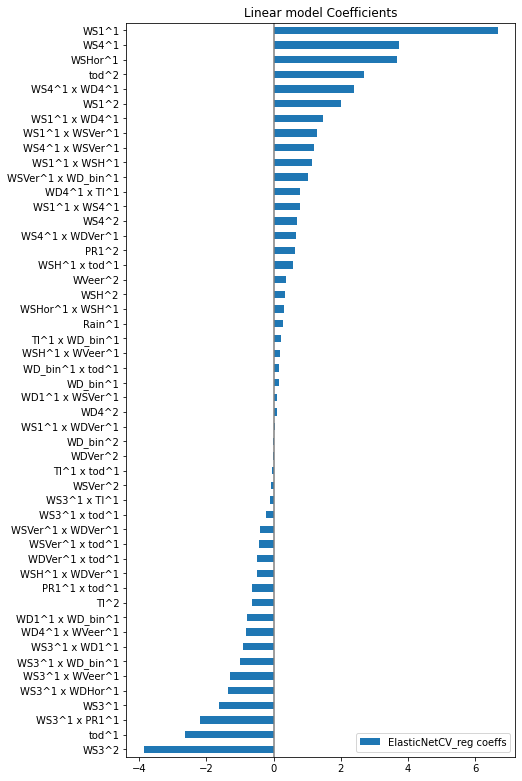

In [33]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
degree=2
model='elasticnet'
cv=4


polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Feature Importance

In [25]:
X_test_poly=PolynomialFeatures_labeled(X_test,2)

In [26]:
X_train_poly=PolynomialFeatures_labeled(X_train,2)

Permutation explainer: 1875it [36:04,  1.16s/it]                          


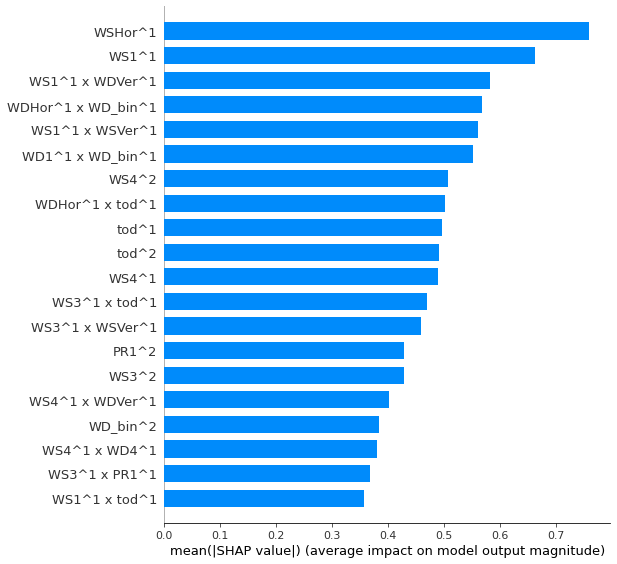

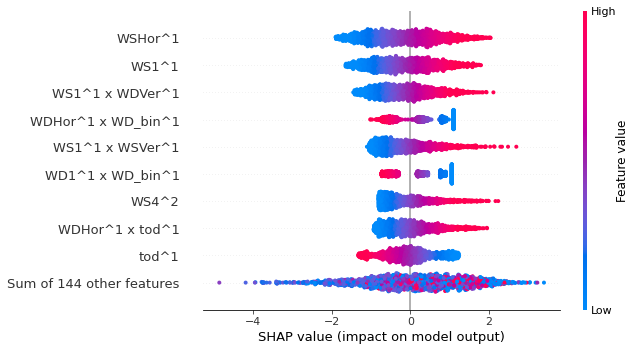

Feature importance through SHAP values performed


In [27]:
shap_values=feature_importance (X_train_poly, X_test_poly, model)

In [28]:
k=transform_shap (shap_values, X_test_poly)

In [29]:
save(k,'\Dataset1-Normal_Site','\SHAP_T17_LR.csv')

file \SHAP_T17_LR.csv saved in \Dataset1-Normal_Site folder


## Dataset2- T22

In [21]:
#upload the dataset with file_folder, file_name
X_train= uploading_csv('\Dataset2-Complex_Site','\X_train22.csv')
X_test= uploading_csv('\Dataset2-Complex_Site','\X_test22.csv')
y_train= uploading_csv('\Dataset2-Complex_Site','\y_train22.csv')
y_test= uploading_csv('\Dataset2-Complex_Site','\y_test22.csv')

X_test.keys()

Index(['WS1', 'WS3', 'WS4', 'WD1', 'WD4', 'WSHor', 'WSVer', 'WDHor', 'RH1',
       'PR1', 'Rain', 'WSH', 'WVeer', 'TI', 'WDVer', 'WD_bin', 'tod'],
      dtype='object')

In [22]:
y_test.keys()

Index(['Target'], dtype='object')

In [23]:
PC= uploading_csv('\Dataset2-Complex_Site','\PC_V117.csv')

### Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.973 m/s as root mean
Wind MAE:  0.758 m/s in avg
Wind MAPE:  9.967 %
Power RMSE:  434.538 kW as root mean
Power MAE:  304.593 kW in avg
Power MAPE:  1.0823115963146416e+17 %

Modelling errors for test set:
Wind RMSE:  0.955 m/s as root mean
Wind MAE:  0.735 m/s in avg
Wind MAPE:  9.4 %
Power RMSE:  429.459 kW as root mean
Power MAE:  294.182 kW in avg
Power MAPE:  28.359 %

Showing the results of the modelling: 
Linear regression & results performed


LinearRegression()

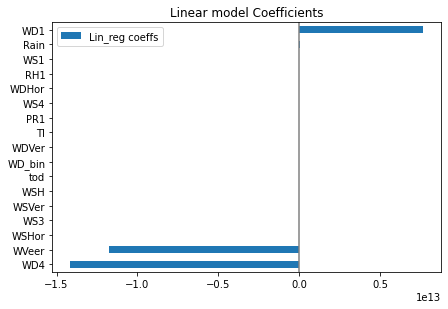

In [24]:
#results with all the variables
linear_regression(X_train, X_test, y_train, y_test, PC, plot=False)

### Polynomial Linear regression

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.806 m/s as root mean
Wind MAE:  0.627 m/s in avg
Wind MAPE:  8.306 %
Power RMSE:  363.17 kW as root mean
Power MAE:  250.952 kW in avg
Power MAPE:  5.747825059525565e+16 %

Modelling errors for test set:
Wind RMSE:  0.812 m/s as root mean
Wind MAE:  0.621 m/s in avg
Wind MAPE:  8.023 %
Power RMSE:  379.709 kW as root mean
Power MAE:  250.836 kW in avg
Power MAPE:  23.625 %

Showing the results of the modelling: 
Linear regression & results performed

Polynomial regression & results performed


LinearRegression()

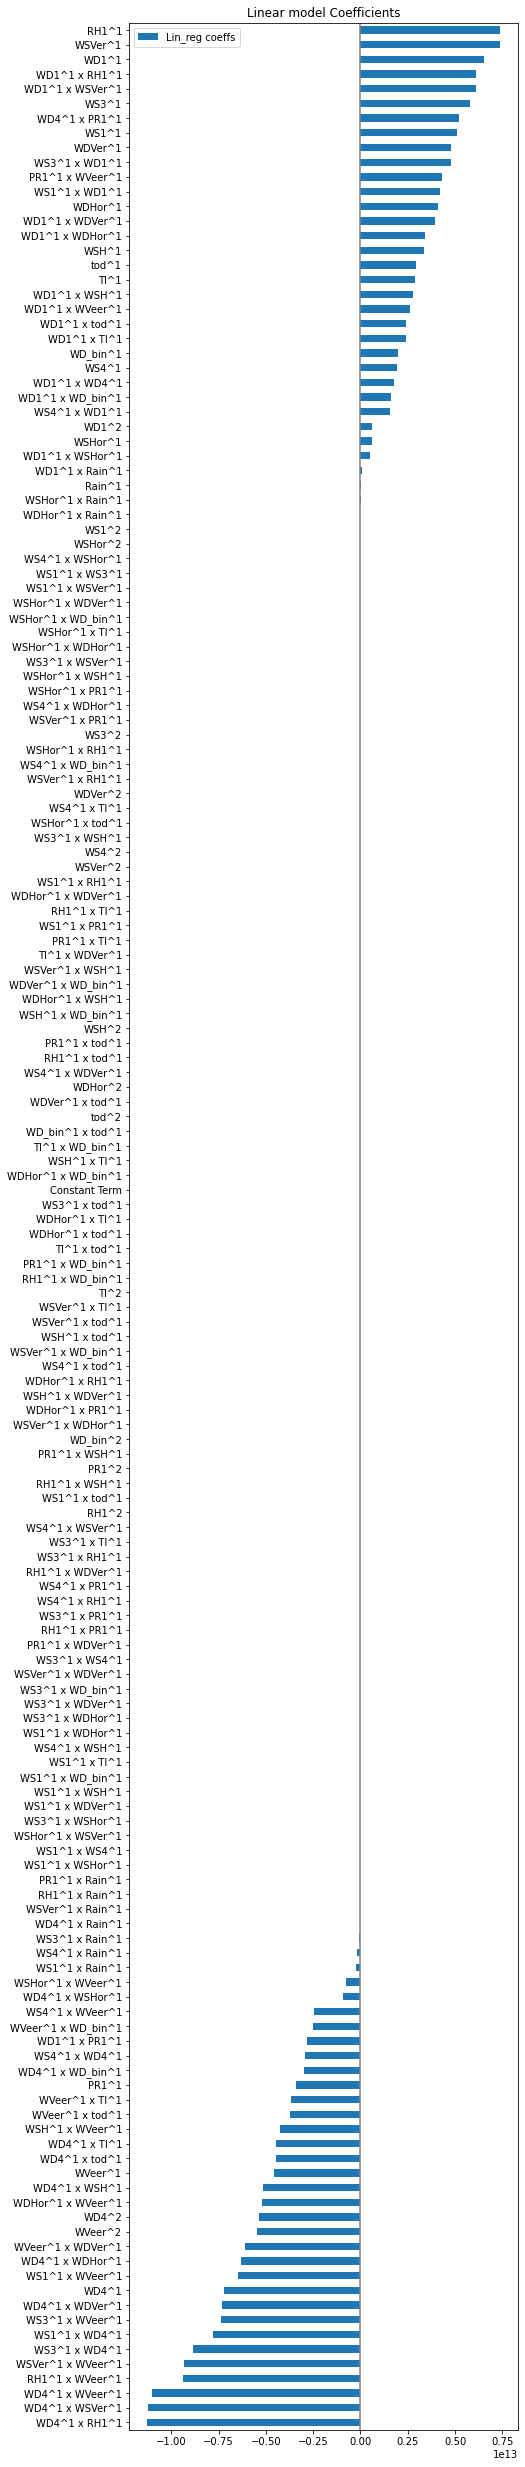

In [25]:
degree=2
cv=None
alphas=None
model='linear'
l1_ratios=None
polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Ridge regression

Best alpha:  0.0004

Of 17 coefficients, 16 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.973 m/s as root mean
Wind MAE:  0.758 m/s in avg
Wind MAPE:  9.967 %
Power RMSE:  434.575 kW as root mean
Power MAE:  304.637 kW in avg
Power MAPE:  1.0815877735475666e+17 %

Modelling errors for test set:
Wind RMSE:  0.955 m/s as root mean
Wind MAE:  0.735 m/s in avg
Wind MAPE:  9.399 %
Power RMSE:  429.477 kW as root mean
Power MAE:  294.188 kW in avg
Power MAPE:  28.35 %

Showing the results of the modelling: 

RidgeCV regression & results performed


RidgeCV(alphas=array([3.0e-04, 4.0e-04, 5.0e-04, 1.0e-03, 3.0e-03, 5.0e-03, 1.0e-02,
       3.0e-02, 5.0e-02, 1.0e-01, 3.0e-01, 5.0e-01, 1.0e+01, 5.0e+01,
       8.0e+01, 1.2e+02, 3.0e+02, 5.0e+02]),
        cv=4)

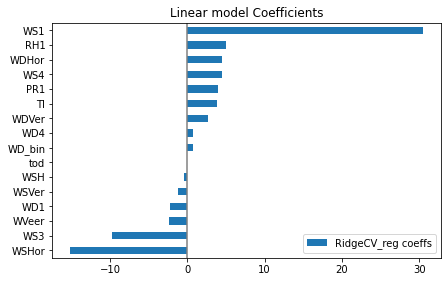

In [26]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
ridgecv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Ridge regression

Best alpha:  0.001

Of 171 coefficients, 152 are non-zero with RidgeCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.814 m/s as root mean
Wind MAE:  0.633 m/s in avg
Wind MAPE:  8.389 %
Power RMSE:  366.72 kW as root mean
Power MAE:  253.783 kW in avg
Power MAPE:  6.008745174803349e+16 %

Modelling errors for test set:
Wind RMSE:  0.811 m/s as root mean
Wind MAE:  0.621 m/s in avg
Wind MAPE:  8.011 %
Power RMSE:  380.382 kW as root mean
Power MAE:  251.892 kW in avg
Power MAPE:  23.601 %

Showing the results of the modelling: 

RidgeCV regression & results performed

Polynomial regression & results performed


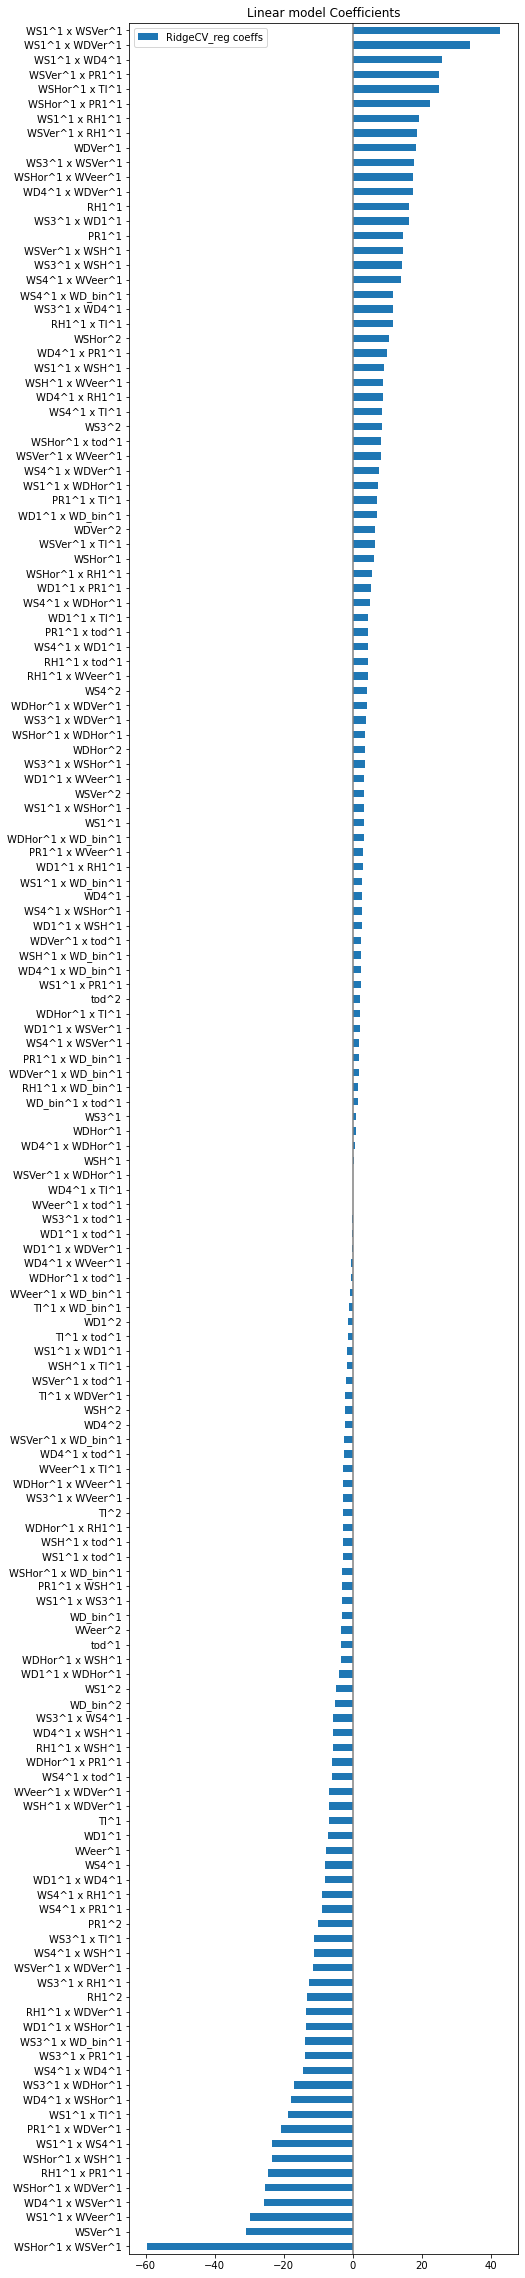

In [33]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='ridge'
cv=4
l1_ratios=None


model=polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Lasso regression

Best alpha:  0.0003

Of 17 coefficients, 14 are non-zero with LassoCV.


Objective did not converge. You might want to increase the number of iterations. Duality gap: 81.67251805938395, tolerance: 2.6194321355499306



power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.976 m/s as root mean
Wind MAE:  0.759 m/s in avg
Wind MAPE:  9.975 %
Power RMSE:  435.609 kW as root mean
Power MAE:  304.907 kW in avg
Power MAPE:  1.1140736227014829e+17 %

Modelling errors for test set:
Wind RMSE:  0.956 m/s as root mean
Wind MAE:  0.735 m/s in avg
Wind MAPE:  9.389 %
Power RMSE:  429.383 kW as root mean
Power MAE:  294.039 kW in avg
Power MAPE:  28.225 %

Showing the results of the modelling: 

LassoCV regression & results performed


LassoCV(alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05,
                0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500],
        cv=4)

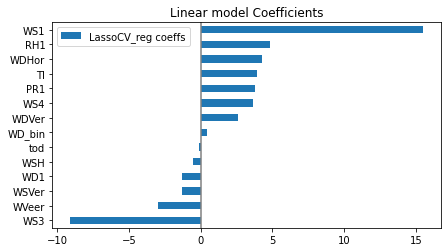

In [28]:
alphas=[0.0003, 0.0004, 0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
cv=4
lassocv_regression(X_train, X_test, y_train, y_test, cv, alphas, PC, plot=False)

### Polynomial Lasso regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5248670889932328, tolerance: 1.967262670386752
Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.559981069294736, tolerance: 1.967262670386752
Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3813496399516225, tolerance: 1.9708036985006763
Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.594086012038133, tolerance: 1.9708036985006763
Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6439918551695882, tolerance: 1.9563751151381683
Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.37417502999233, tolerance: 1.9563751151381683
Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.778136420514329, tolerance: 1.96239157825521

Best alpha:  0.0005

Of 171 coefficients, 48 are non-zero with LassoCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.855 m/s as root mean
Wind MAE:  0.661 m/s in avg
Wind MAPE:  8.726 %
Power RMSE:  384.396 kW as root mean
Power MAE:  263.988 kW in avg
Power MAPE:  7.070885730155584e+16 %

Modelling errors for test set:
Wind RMSE:  0.834 m/s as root mean
Wind MAE:  0.637 m/s in avg
Wind MAPE:  8.195 %
Power RMSE:  384.658 kW as root mean
Power MAE:  256.241 kW in avg
Power MAPE:  24.392 %

Showing the results of the modelling: 

LassoCV regression & results performed

Polynomial regression & results performed


LassoCV(alphas=[0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5,
                10, 50, 80, 120, 300, 500],
        cv=4)

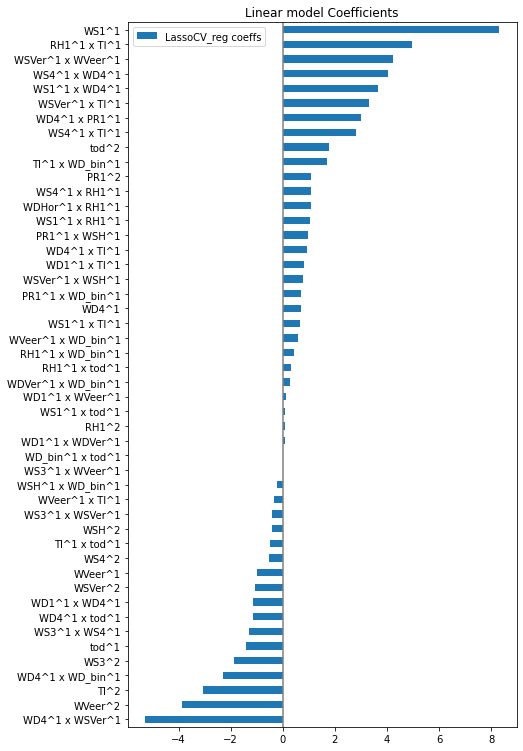

In [30]:
alphas=[0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 10, 50, 80, 120, 300, 500]
degree=2
model='lasso'
cv=4
l1_ratios=None
polynomial_regression(degree, model, cv,  alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### ElasticNet regression

Best alpha:  0.001

Best l1_ratio:  0.9
Of 17 coefficients, 13 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.989 m/s as root mean
Wind MAE:  0.77 m/s in avg
Wind MAPE:  10.099 %
Power RMSE:  440.64 kW as root mean
Power MAE:  308.588 kW in avg
Power MAPE:  1.1521078668186717e+17 %

Modelling errors for test set:
Wind RMSE:  0.968 m/s as root mean
Wind MAE:  0.745 m/s in avg
Wind MAPE:  9.497 %
Power RMSE:  433.82 kW as root mean
Power MAE:  296.878 kW in avg
Power MAPE:  28.523 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.012], cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

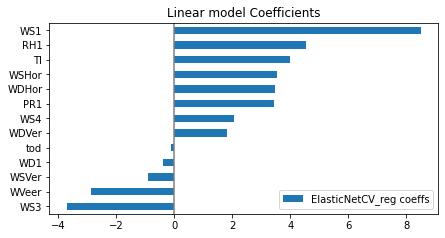

In [31]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.001, 0.002, 0.003, 0.004, 0.008, 0.01, 0.012]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

Best alpha:  0.0005

Best l1_ratio:  0.9
Of 17 coefficients, 15 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.98 m/s as root mean
Wind MAE:  0.763 m/s in avg
Wind MAPE:  10.019 %
Power RMSE:  437.459 kW as root mean
Power MAE:  306.086 kW in avg
Power MAPE:  1.1387487607011243e+17 %

Modelling errors for test set:
Wind RMSE:  0.96 m/s as root mean
Wind MAE:  0.738 m/s in avg
Wind MAPE:  9.422 %
Power RMSE:  430.851 kW as root mean
Power MAE:  294.886 kW in avg
Power MAPE:  28.31 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed


ElasticNetCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

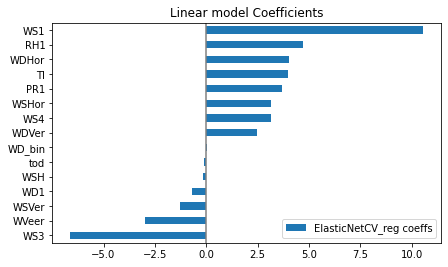

In [32]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
cv=4
elasticnetcv_regression(X_train, X_test, y_train, y_test, cv, alphas, l1_ratios, PC, plot=False)

### Polynomial ElasticNet regression

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.300572792167259, tolerance: 1.9541776917540967


Best alpha:  0.0005

Best l1_ratio:  0.9
Of 210 coefficients, 69 are non-zero with ElasticNetCV.

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.858 m/s as root mean
Wind MAE:  0.662 m/s in avg
Wind MAPE:  8.759 %
Power RMSE:  387.502 kW as root mean
Power MAE:  265.502 kW in avg
Power MAPE:  7.493422654252816e+16 %

Modelling errors for test set:
Wind RMSE:  0.792 m/s as root mean
Wind MAE:  0.613 m/s in avg
Wind MAPE:  7.842 %
Power RMSE:  371.307 kW as root mean
Power MAE:  248.031 kW in avg
Power MAPE:  22.981 %

Showing the results of the modelling: 

ElasticNetCV regression & results performed

Polynomial regression & results performed


ElasticNetCV(alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007],
             cv=4,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
             max_iter=10000.0)

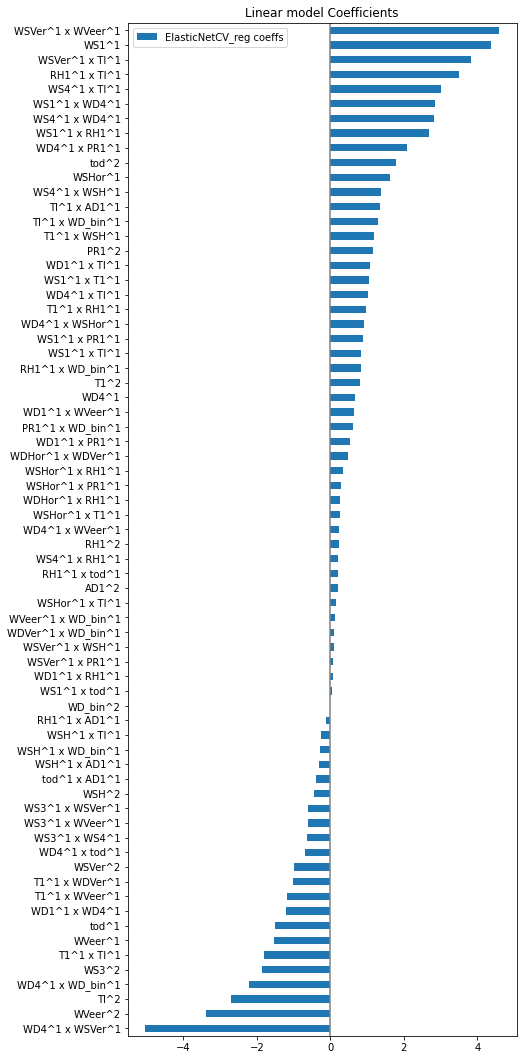

In [91]:
l1_ratios=np.linspace(0.1, 0.9, 9)
alphas=[0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
degree=2
model='elasticnet'
cv=4


polynomial_regression(degree, model, cv, alphas, l1_ratios, X_train, X_test, y_train, y_test, PC, plot=False)

### Feature Importance

In [34]:
X_test_poly=PolynomialFeatures_labeled(X_test,2)

In [35]:
X_train_poly=PolynomialFeatures_labeled(X_train,2)

Permutation explainer: 1723it [29:22,  1.02s/it]                          


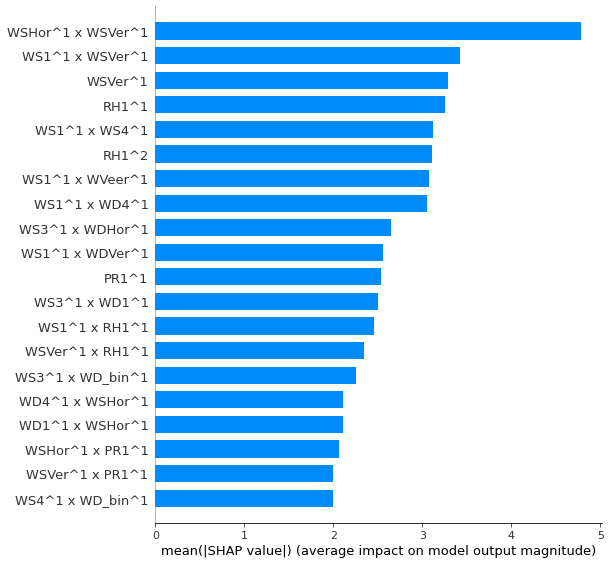

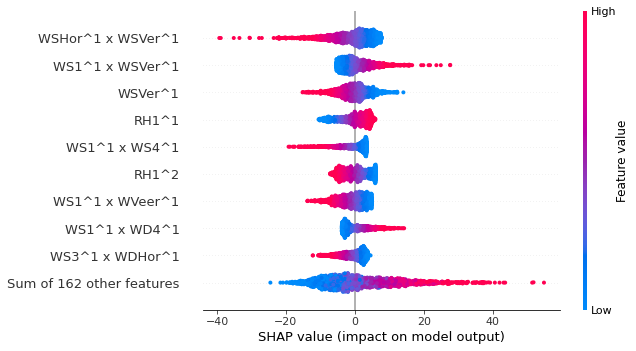

Feature importance through SHAP values performed


In [37]:
shap_values=feature_importance (X_train_poly, X_test_poly, model)

In [38]:
k=transform_shap (shap_values, X_test_poly)

In [39]:
save(k,'\Dataset2-Complex_Site','\SHAP_T22_LR.csv')

file \SHAP_T22_LR.csv saved in \Dataset2-Complex_Site folder
